# Sector Rotation Strategy With Dynamic Rebalancing using Tactical Overlay from ML Model Predictions

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from pandas_datareader import data as pdr
import datetime as dt
from scipy.stats import zscore
from datetime import datetime
import seaborn as sns 
import statsmodels.api as sm
from scipy.optimize import minimize
from itertools import product

from scipy.stats import kurtosis, skew
from scipy.stats import norm
from statsmodels.regression.rolling import RollingOLS
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from utils import *

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from newfuncs import *

years_back = 10
end_date = datetime.now()
start_date = end_date - timedelta(days=years_back*365) 

# Market Data

In [9]:
buckets = pd.read_excel('data/ticker_buckets_0626.xlsx', skiprows=1)
buckets.columns = ['Bucket', 'x', 'Ticker']
buckets = buckets.drop(columns='x')

In [11]:
SP500_tickers = buckets[buckets['Bucket'] == 'SP500'].get('Ticker').tolist()
SP500_tickers = SP500_tickers[0].split(',')
SP500 = [ticker.replace('.', '-') if ticker in ['BRK.B', 'BF.B'] else ticker for ticker in SP500_tickers] # Yahoo Finance uses '-' instead of '.' for BRK.B

stock_data = download_yf_data(SP500, start_date, end_date)
stock_data.to_csv(f'data/SP500_{end_date.year}_{end_date.month}_{end_date.day}.csv')

In [14]:
sector_etfs = buckets[buckets['Bucket'] == 'Sectors'].get('Ticker').tolist()
sector_etfs = sector_etfs[0].split(',')
sector_etfs

sector_data = download_yf_data(sector_etfs, start_date, end_date)
SPY = download_yf_data(['SPY'], start_date, end_date)

In [16]:
sector_labels = ['Energy', 'Financials', 'Information Technology', 'Communication Services', 'Industrials', 
                'Consumer Staples', 'Health Care', 'Consumer Discretionary', 'Utilities', 'Real Estate', 'Materials']
sector_dict = dict(zip(sector_etfs, sector_labels))

In [17]:
model_preds = pd.read_csv('data/sector_pred_hist.csv')
model_preds['ticker'] = model_preds['ticker'].map(sector_dict)

model_preds

,date,ticker,_close,_volume,_5day_center,_5day_center_per,_5day_confidence,_10day_center,_10day_center_per,_10day_confidence,_20day_center,_20day_center_per,_20day_confidence
0,2019-06-03,Materials,54.410000,13155424.0,52.755442,-3.040907,medium,54.389294,-0.038055,high,56.411617,3.678767,high
1,2019-06-04,Materials,55.940000,17778221.0,55.767258,-0.308799,medium,56.750631,1.449107,high,57.649466,3.055892,high
2,2019-06-05,Materials,56.350000,19704292.0,54.700100,-2.927951,medium,54.827187,-2.702418,high,54.596550,-3.111712,high
3,2019-06-06,Materials,57.020000,19911719.0,55.702537,-2.310527,medium,55.757131,-2.214783,high,56.208395,-1.423370,high
4,2019-06-07,Materials,57.530000,23211132.0,58.041696,0.889442,medium,57.971272,0.767030,high,58.568682,1.805461,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13175,2024-07-19,Consumer Discretionary,187.809998,1934996.0,189.671641,0.991238,medium,192.063790,2.264945,high,195.941663,4.329730,high
13176,2024-07-22,Consumer Discretionary,189.880005,2404220.0,194.676765,2.526206,high,197.195060,3.852462,high,200.262118,5.467723,high
13177,2024-07-23,Consumer Discretionary,189.029999,2406314.0,194.710804,3.005240,medium,195.821545,3.592840,high,196.898440,4.162536,high
13178,2024-07-24,Consumer Discretionary,181.300003,4098931.0,180.560569,-0.407851,medium,179.080622,-1.224148,high,174.357064,-3.829531,high


In [18]:
sector_data.columns = sector_data.columns.map(sector_dict)
sector_data.dropna(inplace=True)
sector_data

,Energy,Financials,Information Technology,Communication Services,Industrials,Consumer Staples,Health Care,Consumer Discretionary,Utilities,Real Estate,Materials
Date,,,,,,,,,,,
2018-06-19,56.185593,24.224615,67.086479,47.302952,65.860718,43.398144,76.591507,105.357323,41.396290,25.688457,51.674053
2018-06-20,56.433670,24.162615,67.227341,47.889977,65.905663,43.440647,76.753952,105.856865,41.429279,25.965733,51.506191
2018-06-21,55.388744,24.091757,66.710785,47.596462,65.078262,43.525642,76.311707,105.102867,41.569500,26.120676,50.958454
2018-06-22,56.493809,23.976606,66.494789,47.804768,65.303116,43.882610,76.654694,104.923767,41.858177,26.349018,51.700554
2018-06-25,55.358677,23.719755,65.114182,46.820076,64.475677,44.103607,75.950676,102.642792,42.551003,26.283777,50.896606
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-09,89.410004,42.400002,205.630005,85.209999,124.279999,79.150002,149.979996,174.339996,73.610001,41.810001,88.559998
2024-08-12,89.849998,42.180000,207.309998,84.620003,123.650002,78.750000,149.410004,173.649994,73.739998,41.560001,88.169998
2024-08-13,88.980003,42.529999,213.679993,85.720001,124.949997,79.110001,151.220001,178.000000,74.169998,41.849998,89.050003


In [19]:
sector_returns = sector_data.pct_change().dropna()
SPY_ret = SPY.pct_change().dropna().loc[list(sector_returns.index)]
performance_summary(sector_returns, 252).sort_values(by='Sharpe Ratio', ascending=False)

,Mean,Volatility,Sharpe Ratio,Sortino Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Peak,Bottom,Recovery
Information Technology,0.229867,0.267406,0.859617,0.827176,-0.178489,7.368735,-0.025209,-0.038649,-0.138140,0.117319,-0.335591,2021-12-27,2022-10-12,2023-06-15
Health Care,0.128314,0.178939,0.717085,0.700747,-0.189634,10.592158,-0.015767,-0.026194,-0.098610,0.077057,-0.284043,2020-01-22,2020-03-23,2020-07-15
Consumer Staples,0.113259,0.162065,0.698848,0.673420,-0.213642,15.963159,-0.014238,-0.023539,-0.093956,0.085106,-0.245122,2020-02-14,2020-03-23,2020-08-12
Industrials,0.131969,0.222940,0.591946,0.563448,-0.293944,12.511439,-0.020180,-0.032552,-0.113441,0.126512,-0.423341,2020-02-12,2020-03-23,2020-11-09
Utilities,0.118163,0.216418,0.545992,0.522253,0.131792,15.715230,-0.018615,-0.031349,-0.113577,0.127934,-0.360668,2020-02-18,2020-03-23,2021-08-05
Communication Services,0.125106,0.235561,0.531099,0.501007,-0.362248,5.866195,-0.022520,-0.035492,-0.112795,0.089901,-0.466536,2021-09-01,2022-11-03,2024-06-04
Materials,0.117426,0.229110,0.512532,0.496355,-0.258765,9.103461,-0.020944,-0.032688,-0.110084,0.117601,-0.371439,2019-12-31,2020-03-23,2020-07-17
Financials,0.126002,0.248361,0.507335,0.491548,-0.205630,14.333798,-0.022423,-0.036047,-0.137093,0.131566,-0.428625,2020-02-14,2020-03-23,2021-01-06
Consumer Discretionary,0.119651,0.244596,0.489179,0.451763,-0.537641,6.758556,-0.024295,-0.036924,-0.126686,0.093796,-0.396696,2021-11-19,2022-12-28,NaT
Real Estate,0.107056,0.233731,0.458032,0.429086,-0.708274,14.296630,-0.020938,-0.034323,-0.160012,0.087801,-0.388248,2020-02-21,2020-03-23,2021-04-05


<Axes: xlabel='Date'>

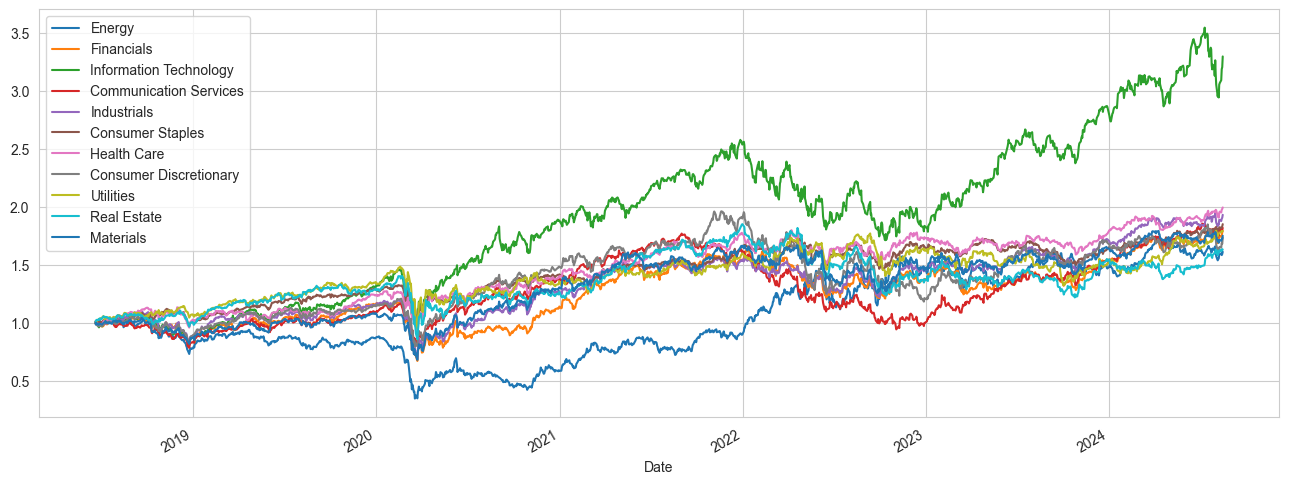

In [21]:
cum_returns = (1 + sector_returns).cumprod()
cum_returns.plot()

In [25]:
def equal_weighted_portfolio(n):
    return np.array([1/n] * n)

def minimum_risk_portfolio(returns):
    n = returns.shape[1]
    cov_matrix = returns.cov()
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(n))
    result = minimize(lambda x: np.dot(x.T, np.dot(cov_matrix, x)), n*[1./n], method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

def mean_variance_optimal_portfolio(returns, risk_free_rate=0):
    n = returns.shape[1]
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    
    def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate):
        returns = np.sum(mean_returns * weights)
        std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return std, returns

    def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
        p_var, p_ret = portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)
        return - (p_ret - risk_free_rate) / p_var

    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(n))
    result = minimize(neg_sharpe_ratio, n*[1./n], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

def mean_variance_optimal_portfolio_constrained(returns, max_exposure=0.2, risk_free_rate=0):
    n = returns.shape[1]
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    
    def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate):
        returns = np.sum(mean_returns * weights)
        std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return std, returns

    def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
        p_var, p_ret = portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)
        return - (p_ret - risk_free_rate) / p_var

    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, max_exposure) for _ in range(n))
    result = minimize(neg_sharpe_ratio, n*[1./n], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

def ridge_regression_portfolio(returns, SPY, alpha=1.0, max_exposure=0.2):
    n = returns.shape[1]
    # Align the indices of returns and SPY
    aligned_data = returns.join(SPY, how='inner').dropna()
    X = aligned_data[returns.columns].values
    y = aligned_data['SPY'].values  # Assuming SPY is a Series with a name attribute

    # Fit the Ridge regression model
    ridge = Ridge(alpha=alpha)
    ridge.fit(X, y)
    
    # Extract and normalize the weights
    raw_weights = ridge.coef_
    clipped_weights = np.clip(raw_weights, 0, max_exposure)
    
    # Normalize weights so that their sum is 1
    if clipped_weights.sum() != 0:
        normalized_weights = clipped_weights / clipped_weights.sum()
    else:
        normalized_weights = np.ones(n) / n  # Fall back to equal weighting if all weights are zero
    
    return normalized_weights

def rolling_window_portfolio(returns, window, rebalancing_freq, risk_free_rate=0, max_exposure=0.2, alpha=1.0, start_date=None):
    equal_returns = []
    min_risk_returns = []
    mean_var_returns = []
    mean_var_constrained_returns = []
    ridge_returns = []
    
    equal_wt = []
    min_risk_wt = []
    mean_var_wt = []
    mean_var_constrained_wt = []
    ridge_wt = []
    
    dates = []

    if start_date is not None:
        date_range = returns.index[returns.index >= start_date][::rebalancing_freq]
    else:
        date_range = returns.index[window::rebalancing_freq]

    for i, end_date in enumerate(date_range):
        start_date = end_date - pd.DateOffset(days=window)
        rolling_returns = returns[start_date:end_date]

        # Calculate weights
        equal_weights = equal_weighted_portfolio(rolling_returns.shape[1])
        min_risk_weights = minimum_risk_portfolio(rolling_returns)
        mean_var_weights = mean_variance_optimal_portfolio(rolling_returns, risk_free_rate)
        mean_var_constrained_weights = mean_variance_optimal_portfolio_constrained(rolling_returns, max_exposure=max_exposure, risk_free_rate=risk_free_rate)
        ridge_weights = ridge_regression_portfolio(rolling_returns, SPY_ret.loc[rolling_returns.index], alpha=alpha, max_exposure=max_exposure)
        
        # Determine the next rebalancing date
        if i + 1 < len(date_range):
            next_rebalance_date = date_range[i + 1]
        else:
            next_rebalance_date = returns.index[-1]
        
        # Apply weights to each day in the rebalancing interval
        period_dates = returns.index[(returns.index > end_date) & (returns.index <= next_rebalance_date)]

        for date in period_dates:
            if date in returns.index:
                equal_return = np.dot(equal_weights, returns.loc[date])
                min_risk_return = np.dot(min_risk_weights, returns.loc[date])
                mean_var_return = np.dot(mean_var_weights, returns.loc[date])
                mean_var_constrained_return = np.dot(mean_var_constrained_weights, returns.loc[date])
                ridge_return = np.dot(ridge_weights, returns.loc[date])
                
                equal_returns.append(equal_return)
                min_risk_returns.append(min_risk_return)
                mean_var_returns.append(mean_var_return)
                mean_var_constrained_returns.append(mean_var_constrained_return)
                ridge_returns.append(ridge_return)
                
                equal_wt.append(equal_weights)
                min_risk_wt.append(min_risk_weights)
                mean_var_wt.append(mean_var_weights)
                mean_var_constrained_wt.append(mean_var_constrained_weights)
                ridge_wt.append(ridge_weights)
                
                dates.append(date)

    # Convert lists to DataFrames
    equal_wt_df = pd.DataFrame(equal_wt, index=dates, columns=returns.columns)
    min_risk_wt_df = pd.DataFrame(min_risk_wt, index=dates, columns=returns.columns)
    mean_var_wt_df = pd.DataFrame(mean_var_wt, index=dates, columns=returns.columns)
    mean_var_constrained_wt_df = pd.DataFrame(mean_var_constrained_wt, index=dates, columns=returns.columns)
    ridge_wt_df = pd.DataFrame(ridge_wt, index=dates, columns=returns.columns)
    
    equal_returns_df = pd.Series(equal_returns, index=dates)
    min_risk_returns_df = pd.Series(min_risk_returns, index=dates)
    mean_var_returns_df = pd.Series(mean_var_returns, index=dates)
    mean_var_constrained_returns_df = pd.Series(mean_var_constrained_returns, index=dates)
    ridge_returns_df = pd.Series(ridge_returns, index=dates)
    
    return equal_wt_df, min_risk_wt_df, mean_var_wt_df, mean_var_constrained_wt_df, ridge_wt_df, equal_returns_df, min_risk_returns_df, mean_var_returns_df, mean_var_constrained_returns_df, ridge_returns_df

def calculate_cumulative_returns(portfolio_returns):
    cumulative_returns = (1 + portfolio_returns).cumprod()
    return cumulative_returns / cumulative_returns.iloc[0]  # Normalize to start at 1

def sharpe_ratio(portfolio_returns, risk_free_rate=0):
    excess_returns = portfolio_returns - risk_free_rate / 252
    return np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)

def performance_summary(return_data, annualization = 12):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*annualization)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(annualization))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']
    def sortino_ratio(column):
        negative_returns = return_data[column][return_data[column] < 0]
        downside_std = np.sqrt((negative_returns ** 2).mean()) * np.sqrt(annualization)
        return summary_stats.loc[column, 'Mean'] / downside_std if downside_std != 0 else np.nan

    # Apply the sortino_ratio function to each column in return_data
    summary_stats['Sortino Ratio'] = return_data.apply(lambda col: sortino_ratio(col.name), axis=0)

    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    summary_stats['Min'] = return_data.min()
    summary_stats['Max'] = return_data.max()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

def normalize_series(series):
    """
    Normalize a pandas Series to the range [0, 1].
    """
    min_val = series.min()
    max_val = series.max()
    normalized_series = (series - min_val) / (max_val - min_val)
    return normalized_series

def composite_score(performance_stats, weights):
    """
    Calculate a composite score based on performance metrics and given weights.
    """
    # Normalize each metric
    normalized_mean = normalize_series(performance_stats['Mean'])
    normalized_sharpe = normalize_series(performance_stats['Sharpe Ratio'])
    normalized_sortino = normalize_series(performance_stats['Sortino Ratio'])
    normalized_drawdown = 1 - normalize_series(performance_stats['Max Drawdown'])  # Invert to penalize larger drawdowns
    normalized_volatility = normalize_series(performance_stats['Volatility'])
    normalized_skewness = normalize_series(performance_stats['Skewness'])
    
    # Calculate composite score
    score = (normalized_sharpe * weights['Sharpe Ratio'] +
             normalized_sortino * weights['Sortino Ratio'] +
             normalized_mean * weights['Mean'] +
             normalized_drawdown * weights['Max Drawdown'] +
             normalized_volatility * weights['Volatility'] +
             normalized_skewness * weights['Skewness'])
    
    return score


def cross_validate_strategies(returns, window_sizes, rebalancing_freqs, max_exposures, alphas, split_percentages, risk_free_rate=0, performance_weights=None):
    if performance_weights is None:
        performance_weights = {
            'Sharpe Ratio': 0.25,
            'Sortino Ratio': 0.25,
            'Mean': 0.0,
            'Max Drawdown': 0.20,
            'Volatility': -0.15,
            'Skewness': 0.15
        }
    
    # Initialize variables to track the best composite score and corresponding parameters
    best_score = -np.inf
    best_params = None
    results = []

    # Calculate the actual split dates based on the percentages
    split_dates = [returns.index[int(p * len(returns))] for p in split_percentages]

    # Iterate over all combinations of window sizes, rebalancing frequencies, max exposures, and alphas
    for window_size, rebalancing_freq, max_exposure, alpha in product(window_sizes, rebalancing_freqs, max_exposures, alphas):
        composite_scores = []

        # Perform cross-validation with the provided split dates
        for i in range(len(split_dates) - 1):
            # Split data into training and testing sets based on the current split dates
            train_returns = returns[returns.index < split_dates[i]]
            test_returns = returns[(returns.index >= split_dates[i]) & (returns.index < split_dates[i+1])]

            # Calculate portfolio returns for the training set
            _, _, _, _, _, train_equal_returns_df, train_min_risk_returns_df, train_mean_var_returns_df, train_mean_var_constrained_returns_df, train_ridge_returns_df = rolling_window_portfolio(
                train_returns, window_size, rebalancing_freq, risk_free_rate, max_exposure, alpha)

            # Use historical data up to the test period to calculate portfolio weights
            test_start_date = split_dates[i] - pd.DateOffset(days=window_size)
            _, _, _, _, _, test_equal_returns_df, test_min_risk_returns_df, test_mean_var_returns_df, test_mean_var_constrained_returns_df, test_ridge_returns_df = rolling_window_portfolio(
                returns, window_size, rebalancing_freq, risk_free_rate, max_exposure, alpha, start_date=test_start_date)

            # Calculate performance summary for the test set
            test_performance_summary = performance_summary(pd.DataFrame({
                'Equal Weighted': test_equal_returns_df,
                'Min Variance': test_min_risk_returns_df,
                'MVO': test_mean_var_returns_df,
                'MVO Constrained': test_mean_var_constrained_returns_df,
                'Ridge Regression': test_ridge_returns_df
            }), annualization=252)

            # Calculate composite score for each strategy
            test_performance_summary['Composite Score'] = composite_score(test_performance_summary, performance_weights)

            # Find the highest composite score among the different portfolio strategies
            best_strategy_score = test_performance_summary['Composite Score'].max()
            composite_scores.append(best_strategy_score)

        # Calculate the average composite score across all splits
        avg_score = np.mean(composite_scores)
        
        # Append results for the current parameter combination
        results.append({
            'window_size': window_size,
            'rebalancing_freq': rebalancing_freq,
            'max_exposure': max_exposure,
            'alpha': alpha,
            'avg_composite_score': avg_score
        })

        # Update the best parameters if the current average composite score is higher than the best so far
        if avg_score > best_score:
            best_score = avg_score
            best_params = (window_size, rebalancing_freq, max_exposure, alpha)
    
    # Convert results to a DataFrame for easier analysis
    results_df = pd.DataFrame(results)
    
    # Final out-of-sample test
    final_train_end = int(0.8 * len(returns))  # Use 80% of data for training
    final_train_returns = returns[:final_train_end]
    final_test_returns = returns[final_train_end:]
    
    _, _, _, _, _, final_test_equal_returns_df, final_test_min_risk_returns_df, final_test_mean_var_returns_df, final_test_mean_var_constrained_returns_df, final_test_ridge_returns_df = rolling_window_portfolio(
        returns, best_params[0], best_params[1], risk_free_rate, best_params[2], best_params[3], start_date=returns.index[0])
    
    final_test_performance_summary = performance_summary(pd.DataFrame({
        'Equal Weighted': final_test_equal_returns_df,
        'Min Variance': final_test_min_risk_returns_df,
        'MVO': final_test_mean_var_returns_df,
        'MVO Constrained': final_test_mean_var_constrained_returns_df,
        'Ridge Regression': final_test_ridge_returns_df
    }), annualization=252)
    
    final_test_performance_summary['Composite Score'] = composite_score(final_test_performance_summary, performance_weights)
        
    return best_params, results_df, final_test_performance_summary

# Example usage
# Define range of window sizes, rebalancing frequencies, max exposures, and alphas
window_sizes = range(126, 126 * 5, 63)  # 6 months, 1 year, 1.5 years
rebalancing_freqs = range(21, 21 * 12, 21)  # 1 month, 2 months, 3 months, etc.
max_exposures = [0.2, 0.3, 0.4, 0.5]  # Different levels of max exposure constraints
alphas = [0.01, 0.1, 1, 10, 100]  # Different values for the regularization parameter in Ridge regression
split_percentages = [.55, .65, 0.75, .85] # Train-test split percentages

# Perform cross-validation grid search
best_params, results_df, perf_summ = cross_validate_strategies(sector_returns, window_sizes, rebalancing_freqs, max_exposures, alphas, split_percentages)
print(f'Best parameters: {best_params}')

Best parameters: (567, 84, 0.4, 10)


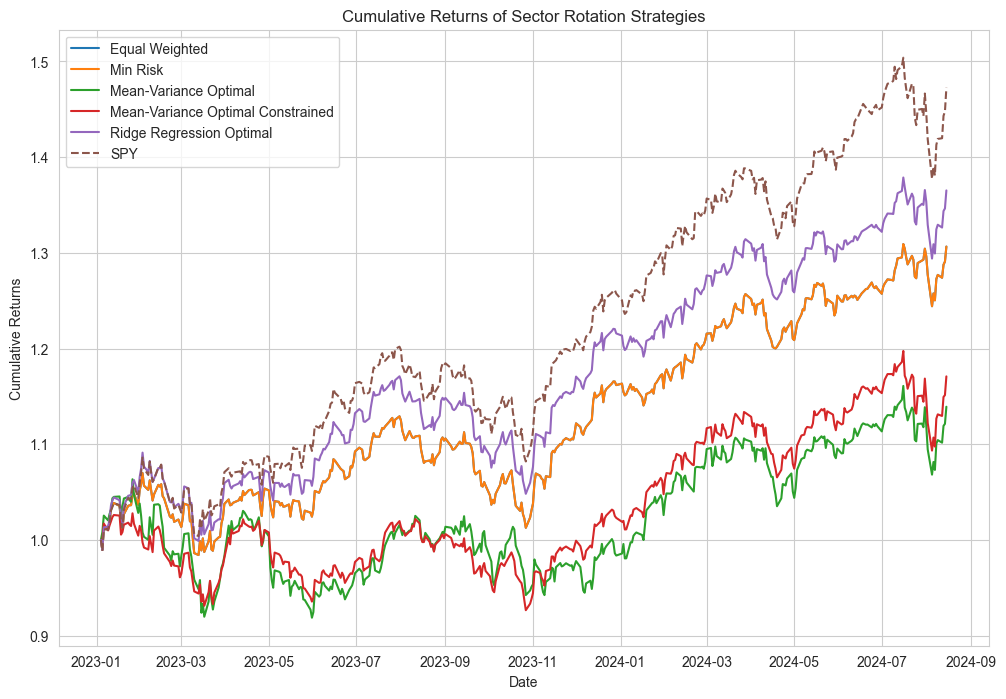

,Mean,Volatility,Sharpe Ratio,Sortino Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Peak,Bottom,Recovery
SPY,0.253348,0.129208,1.960776,1.953066,-0.169960,0.331989,-0.013796,-0.016606,-0.029124,0.023117,-0.099743,2023-07-31,2023-10-27,2023-11-30
Ridge Regression,0.208193,0.126432,1.646679,1.649328,-0.147336,0.356186,-0.013694,-0.016651,-0.026564,0.024171,-0.104832,2023-07-31,2023-10-27,2023-12-11
Equal Weighted,0.179591,0.118968,1.509577,1.501162,-0.150638,0.447522,-0.012828,-0.015716,-0.025701,0.023480,-0.103128,2023-07-31,2023-10-27,2023-12-13
Min Risk,0.179591,0.118968,1.509577,1.501162,-0.150638,0.447522,-0.012828,-0.015716,-0.025701,0.023480,-0.103128,2023-07-31,2023-10-27,2023-12-13
MVO Constrained,0.108381,0.132807,0.816080,0.838997,-0.056598,0.464753,-0.013177,-0.017475,-0.029058,0.026622,-0.098435,2023-01-26,2023-10-27,2023-12-26
Mean-Variance,0.094497,0.159380,0.592903,0.594422,-0.028885,0.554373,-0.015675,-0.020403,-0.035624,0.032593,-0.136015,2023-01-26,2023-05-31,2024-02-09


In [133]:
window_size, rebalancing_freq, max_exposure, alpha = best_params
d1 ='2023-01-01'

equal_wt_df, min_risk_wt_df, mean_var_wt_df, mean_var_constrained_wt_df, ridge_wt_df, test_equal_returns_df, test_min_risk_returns_df,\
test_mean_var_returns_df, test_mean_var_constrained_returns_df, test_ridge_returns_df = \
rolling_window_portfolio(sector_returns, window=window_size, rebalancing_freq=rebalancing_freq, risk_free_rate=0, max_exposure=max_exposure, alpha=alpha, start_date=d1)

# Calculate cumulative returns for comparison
test_ew_cumulative_returns = calculate_cumulative_returns(test_equal_returns_df)
test_min_risk_cumulative_returns = calculate_cumulative_returns(test_min_risk_returns_df)
test_mvo_cumulative_returns = calculate_cumulative_returns(test_mean_var_returns_df)
test_mvo_constrained_cumulative_returns = calculate_cumulative_returns(test_mean_var_constrained_returns_df)
test_ridge_cumulative_returns = calculate_cumulative_returns(test_ridge_returns_df)
test_spy_cumulative_returns = calculate_cumulative_returns(SPY_ret.loc[test_equal_returns_df.index])

# Plot cumulative returns
plt.figure(figsize=(12, 8))
plt.plot(test_ew_cumulative_returns, label='Equal Weighted')
plt.plot(test_min_risk_cumulative_returns, label='Min Risk')
plt.plot(test_mvo_cumulative_returns, label='Mean-Variance Optimal')
plt.plot(test_mvo_constrained_cumulative_returns, label='Mean-Variance Optimal Constrained')
plt.plot(test_ridge_cumulative_returns, label='Ridge Regression Optimal')
plt.plot(test_spy_cumulative_returns, label='SPY', linestyle='--')
plt.title('Cumulative Returns of Sector Rotation Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

# Performance summary
performance = performance_summary(pd.DataFrame({
    'Equal Weighted': test_equal_returns_df,
    'Min Risk': test_min_risk_returns_df,
    'Mean-Variance': test_mean_var_returns_df,
    'MVO Constrained': test_mean_var_constrained_returns_df,
    'Ridge Regression': test_ridge_returns_df,
    'SPY': SPY_ret.loc[test_equal_returns_df.index]['SPY'].values
}), annualization=252)

performance.sort_values(by='Sharpe Ratio', ascending=False)

# Tactical Overlay

In [134]:
# model_preds_pivot = model_preds.pivot(index='date', columns='ticker', values=['_5day_center_per', '_5day_confidence'])
# model_preds_pivot['_5day_center_per'] = model_preds_pivot['_5day_center_per'].fillna(0)
# model_preds_pivot['_5day_confidence'] = model_preds_pivot['_5day_confidence'].fillna('low')
# model_preds_pivot

mp1 = model_preds
mp1['date'] = pd.to_datetime(mp1['date'])
mp1

,date,ticker,_close,_volume,_5day_center,_5day_center_per,_5day_confidence,_10day_center,_10day_center_per,_10day_confidence,_20day_center,_20day_center_per,_20day_confidence
0,2019-06-03,Materials,54.410000,13155424.0,52.755442,-3.040907,medium,54.389294,-0.038055,high,56.411617,3.678767,high
1,2019-06-04,Materials,55.940000,17778221.0,55.767258,-0.308799,medium,56.750631,1.449107,high,57.649466,3.055892,high
2,2019-06-05,Materials,56.350000,19704292.0,54.700100,-2.927951,medium,54.827187,-2.702418,high,54.596550,-3.111712,high
3,2019-06-06,Materials,57.020000,19911719.0,55.702537,-2.310527,medium,55.757131,-2.214783,high,56.208395,-1.423370,high
4,2019-06-07,Materials,57.530000,23211132.0,58.041696,0.889442,medium,57.971272,0.767030,high,58.568682,1.805461,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13175,2024-07-19,Consumer Discretionary,187.809998,1934996.0,189.671641,0.991238,medium,192.063790,2.264945,high,195.941663,4.329730,high
13176,2024-07-22,Consumer Discretionary,189.880005,2404220.0,194.676765,2.526206,high,197.195060,3.852462,high,200.262118,5.467723,high
13177,2024-07-23,Consumer Discretionary,189.029999,2406314.0,194.710804,3.005240,medium,195.821545,3.592840,high,196.898440,4.162536,high
13178,2024-07-24,Consumer Discretionary,181.300003,4098931.0,180.560569,-0.407851,medium,179.080622,-1.224148,high,174.357064,-3.829531,high


In [135]:
def tactical_overlay_adjustment_over_period(predictions_df, initial_weights, confidence_column='_5day_confidence', prediction_column='_5day_center_per'):
    # Convert initial weights from array to dictionary for easier manipulation
    adjusted_weights = {sector: weight for sector, weight in zip(initial_weights.index, initial_weights)}

    # Define the mapping of confidence levels to adjustment factors
    confidence_factors = {
        'low': .80,    # Reduce weight by 10% if confidence is low
        'medium': 1.0, # No change if confidence is medium
        'high': 1.5    # Increase weight by 1.5x if confidence is high
    }

    # Iterate over predictions within the rebalancing period
    for _, row in predictions_df.iterrows():
        sector = row['ticker']
        confidence = row[confidence_column]
        prediction = row[prediction_column]
        
        adjustment_factor = confidence_factors.get(confidence)

        if adjustment_factor is None or sector not in adjusted_weights:
            continue  # Skip invalid confidence levels or sectors not in weights
        
        if prediction > 0 and confidence == 'high':
            adjusted_weights[sector] *= adjustment_factor
        
    # Normalize the weights to ensure they sum to 1 (100%)
    total_weight = sum(adjusted_weights.values())
    for sector in adjusted_weights:
        adjusted_weights[sector] /= total_weight
    
    # Convert adjusted weights back to array format
    adjusted_weights_array = np.array([adjusted_weights[sector] for sector in initial_weights.index])

    return adjusted_weights_array

def rolling_window_portfolio_with_tactical_overlay(returns, predictions_df, window, rebalancing_freq, risk_free_rate=0, max_exposure=0.2, alpha=1.0, start_date=None):
    ridge_returns = []
    ridge_wt = []
    dates = []

    if start_date is not None:
        date_range = returns.index[returns.index >= start_date][::rebalancing_freq]
    else:
        date_range = returns.index[window::rebalancing_freq]

    for i, end_date in enumerate(date_range):
        start_date = end_date - pd.DateOffset(days=window)
        rolling_returns = returns[start_date:end_date]

        # Calculate ridge regression weights
        ridge_weights = ridge_regression_portfolio(rolling_returns, SPY_ret.loc[rolling_returns.index], alpha=alpha, max_exposure=max_exposure)
        
        # Convert ridge_weights to a Pandas Series for compatibility with tactical overlay
        ridge_weights = pd.Series(ridge_weights, index=returns.columns)
        
        # Determine the next rebalancing date
        if i + 1 < len(date_range):
            next_rebalance_date = date_range[i + 1]
        else:
            next_rebalance_date = returns.index[-1]

        # Apply tactical overlay within the current rebalancing period
        period_dates = returns.index[(returns.index > end_date) & (returns.index <= next_rebalance_date)]
        
        for j in range(0, len(period_dates), 5):  # Every 5 days within the period
            date_chunk = period_dates[j:j+5]
            predictions_at_time = predictions_df[(predictions_df['date'] >= date_chunk[0]) & (predictions_df['date'] <= date_chunk[-1])]

            if not predictions_at_time.empty:
                adjusted_weights = tactical_overlay_adjustment_over_period(predictions_at_time, ridge_weights)
            else:
                adjusted_weights = ridge_weights.values  # If no predictions, use baseline weights

            # Apply adjusted weights to each day in this 5-day chunk
            for date in date_chunk:
                if date in returns.index:
                    ridge_return = np.dot(adjusted_weights, returns.loc[date])
                    ridge_returns.append(ridge_return)
                    ridge_wt.append(adjusted_weights)
                    dates.append(date)

    # Convert lists to DataFrames
    ridge_wt_df = pd.DataFrame(ridge_wt, index=dates, columns=returns.columns)
    ridge_returns_df = pd.Series(ridge_returns, index=dates)
    
    return ridge_wt_df, ridge_returns_df

ridge_wt, ridge_ret = rolling_window_portfolio_with_tactical_overlay(sector_returns, mp1, window=window_size, rebalancing_freq=rebalancing_freq, risk_free_rate=0, max_exposure=max_exposure, alpha=alpha, start_date=d1)

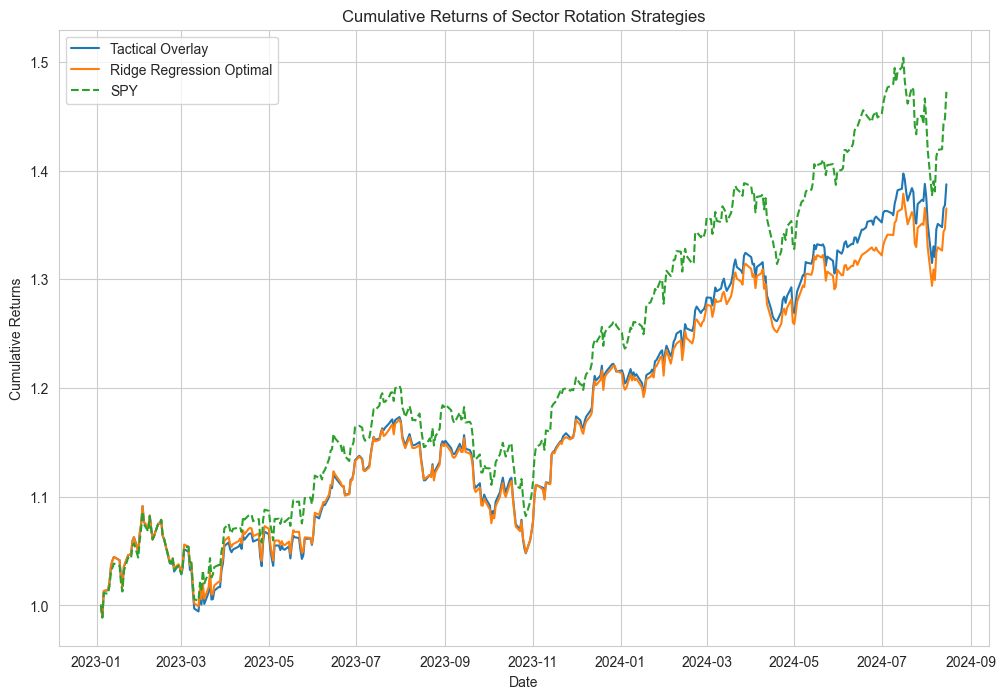

,Mean,Volatility,Sharpe Ratio,Sortino Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Peak,Bottom,Recovery
SPY,0.253348,0.129208,1.960776,1.953066,-0.169960,0.331989,-0.013796,-0.016606,-0.029124,0.023117,-0.099743,2023-07-31,2023-10-27,2023-11-30
Tactical Overlay,0.218062,0.125425,1.738589,1.741714,-0.171847,0.432599,-0.013416,-0.016688,-0.026564,0.023916,-0.106832,2023-07-31,2023-10-27,2023-12-01
Ridge Regression,0.208193,0.126432,1.646679,1.649328,-0.147336,0.356186,-0.013694,-0.016651,-0.026564,0.024171,-0.104832,2023-07-31,2023-10-27,2023-12-11


In [136]:
test_ridge_cumulative_returns = calculate_cumulative_returns(test_ridge_returns_df)
test_spy_cumulative_returns = calculate_cumulative_returns(SPY_ret.loc[test_equal_returns_df.index])
test_tact_cum_returns = calculate_cumulative_returns(ridge_ret)


# Plot cumulative returns
plt.figure(figsize=(12, 8))
plt.plot(test_tact_cum_returns, label='Tactical Overlay')
plt.plot(test_ridge_cumulative_returns, label='Ridge Regression Optimal')
plt.plot(test_spy_cumulative_returns, label='SPY', linestyle='--')
plt.title('Cumulative Returns of Sector Rotation Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

# Performance summary
performance = performance_summary(pd.DataFrame({
    'Tactical Overlay': ridge_ret,
    'Ridge Regression': test_ridge_returns_df,
    'SPY': SPY_ret.loc[test_equal_returns_df.index]['SPY'].values
}), annualization=252)

performance.sort_values(by='Sharpe Ratio', ascending=False)

In [137]:
ridge_wt

,Energy,Financials,Information Technology,Communication Services,Industrials,Consumer Staples,Health Care,Consumer Discretionary,Utilities,Real Estate,Materials
2023-01-04,0.074688,0.096614,0.135513,0.115123,0.088409,0.054643,0.066882,0.131815,0.055324,0.085732,0.095257
2023-01-05,0.074688,0.096614,0.135513,0.115123,0.088409,0.054643,0.066882,0.131815,0.055324,0.085732,0.095257
2023-01-06,0.074688,0.096614,0.135513,0.115123,0.088409,0.054643,0.066882,0.131815,0.055324,0.085732,0.095257
2023-01-09,0.074688,0.096614,0.135513,0.115123,0.088409,0.054643,0.066882,0.131815,0.055324,0.085732,0.095257
2023-01-10,0.074688,0.096614,0.135513,0.115123,0.088409,0.054643,0.066882,0.131815,0.055324,0.085732,0.095257
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-09,0.066261,0.090608,0.137465,0.120816,0.088811,0.049990,0.057712,0.126794,0.061278,0.104866,0.095400
2024-08-12,0.066261,0.090608,0.137465,0.120816,0.088811,0.049990,0.057712,0.126794,0.061278,0.104866,0.095400
2024-08-13,0.066261,0.090608,0.137465,0.120816,0.088811,0.049990,0.057712,0.126794,0.061278,0.104866,0.095400
2024-08-14,0.066261,0.090608,0.137465,0.120816,0.088811,0.049990,0.057712,0.126794,0.061278,0.104866,0.095400


In [138]:
ridge_wt_df

,Energy,Financials,Information Technology,Communication Services,Industrials,Consumer Staples,Health Care,Consumer Discretionary,Utilities,Real Estate,Materials
2023-01-04,0.074688,0.096614,0.135513,0.115123,0.088409,0.054643,0.066882,0.131815,0.055324,0.085732,0.095257
2023-01-05,0.074688,0.096614,0.135513,0.115123,0.088409,0.054643,0.066882,0.131815,0.055324,0.085732,0.095257
2023-01-06,0.074688,0.096614,0.135513,0.115123,0.088409,0.054643,0.066882,0.131815,0.055324,0.085732,0.095257
2023-01-09,0.074688,0.096614,0.135513,0.115123,0.088409,0.054643,0.066882,0.131815,0.055324,0.085732,0.095257
2023-01-10,0.074688,0.096614,0.135513,0.115123,0.088409,0.054643,0.066882,0.131815,0.055324,0.085732,0.095257
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-09,0.066261,0.090608,0.137465,0.120816,0.088811,0.049990,0.057712,0.126794,0.061278,0.104866,0.095400
2024-08-12,0.066261,0.090608,0.137465,0.120816,0.088811,0.049990,0.057712,0.126794,0.061278,0.104866,0.095400
2024-08-13,0.066261,0.090608,0.137465,0.120816,0.088811,0.049990,0.057712,0.126794,0.061278,0.104866,0.095400
2024-08-14,0.066261,0.090608,0.137465,0.120816,0.088811,0.049990,0.057712,0.126794,0.061278,0.104866,0.095400


In [74]:
0.088936 * 1.1

0.0978296